In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from numpy import unique, where
from collections import Counter
from sklearn.cluster import DBSCAN, KMeans
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from sentence_transformers import SentenceTransformer


import sys
sys.path.append("../..")
from util.vis import t_sne, pca
from util.clustering_eval import clustering_summary, print_clustering_classes, clustering_spacy_evaluation

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_data = pd.read_pickle('../../data/04-0c_Test_Set.pkl')

# Sentence BERT

In this third baseline notebook, the SBERT is used, that is also used in the final model.

In [3]:
messages = test_data["message"].tolist()

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

vectors = model.encode(messages, convert_to_numpy=True)

## Centroids

In [4]:
authors_centroids = {}

for group in test_data.groupby('author_email'):
    author_embeddings = np.array(vectors[group[1].index])
    authors_centroids[group[0]] = np.mean(author_embeddings, axis = 0)

In [5]:
centroids_array = [value for value in authors_centroids.values()]

distances = pd.DataFrame(euclidean_distances(centroids_array, centroids_array))

for i in range(len(distances)):
    for j in range(i + 1):
        distances[j][i] = 0

distances.index = ['Author 1', 'Author 2', 'Author 3', 'Author 4', 'Author 5', 'Author 6', 'Author 7']
distances.columns = ['Author 1', 'Author 2', 'Author 3', 'Author 4', 'Author 5', 'Author 6', 'Author 7']

distances.style.background_gradient(cmap='coolwarm').set_precision(3)

,0,1,2,3,4,5,6
0,0.000,0.320,0.277,0.544,0.266,0.375,0.324
1,0.000,0.000,0.310,0.582,0.317,0.399,0.332
2,0.000,0.000,0.000,0.570,0.202,0.271,0.244
3,0.000,0.000,0.000,0.000,0.584,0.621,0.571
4,0.000,0.000,0.000,0.000,0.000,0.289,0.213
5,0.000,0.000,0.000,0.000,0.000,0.000,0.201
6,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## PCA & t-SNE Visualizations

First, the generated vectors are reduced to two and three dimensions with PCA and t-SNE and visualized. Each of the seven authors gets a different color.

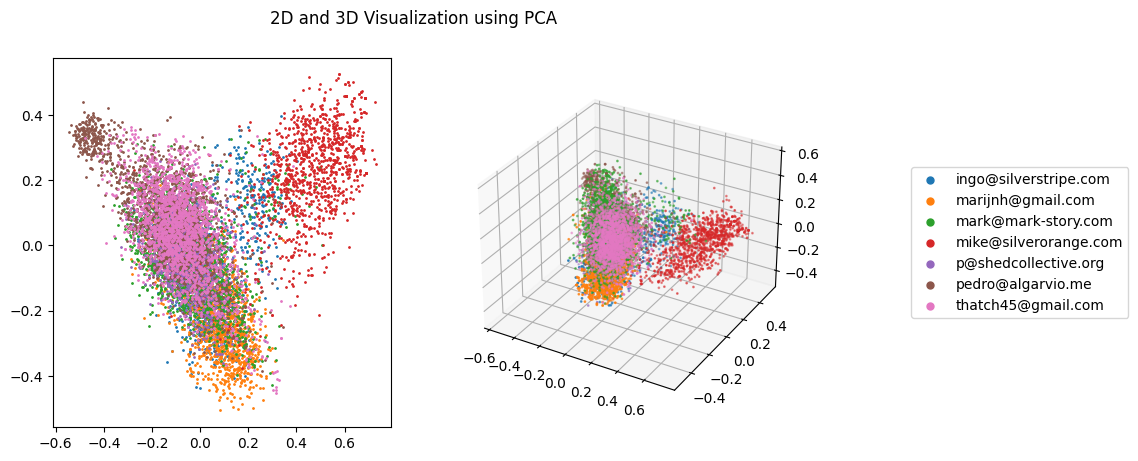

In [6]:
pca_2_prediction, pca_3_prediction = pca(vectors, test_data)

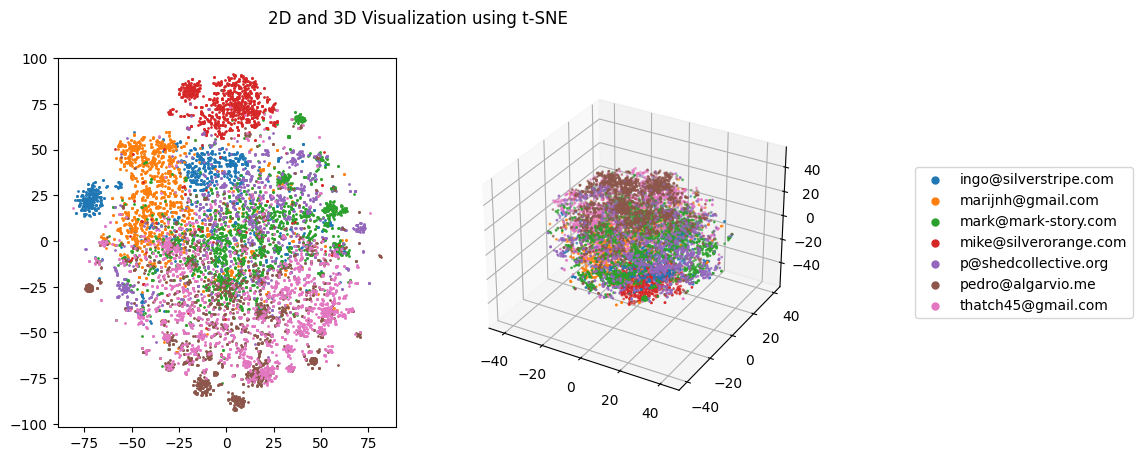

In [7]:
t_sne_2_prediction, t_sne_3_prediction = t_sne(vectors, test_data)

## DBSCAN

DBSCAN: Density-based, no number of clusters needed, ability to provide min_samples to make one cluster

Number of Clusters: 2
10 Most common:
[(0, 5449), (-1, 5235)]


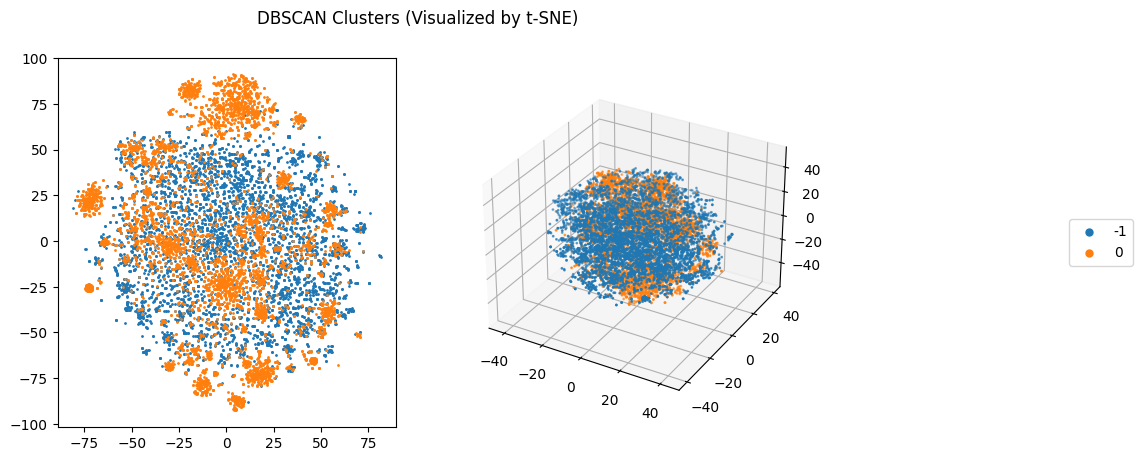

In [8]:
dbscan_model = DBSCAN(eps=1, min_samples=50)
dbscan_prediction = dbscan_model.fit_predict(vectors)

dbscan_clusters = unique(dbscan_prediction)

print(f"Number of Clusters: {len(dbscan_clusters)}")
print("10 Most common:")
print(Counter(dbscan_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for dbscan_cluster in dbscan_clusters:
    index = where(dbscan_prediction == dbscan_cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=dbscan_cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=dbscan_cluster)

fig.suptitle("DBSCAN Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [9]:
dbscan_summary = clustering_summary(dbscan_prediction, test_data)
dbscan_summary

There are 7 different authors.
There are 91 different projects.


,Number of Messages,Number of different Authors,Median number of commits per different Author,Most common Author,Number of different Projects,Median number of commits per different Project,Most common project
0,5235.0,7.0,733.0,"('thatch45@gmail.com', 1250)",86.0,6.0,"('saltstack_salt', 1905)"
1,5449.0,7.0,767.0,"('pedro@algarvio.me', 1204)",68.0,3.0,"('saltstack_salt', 1893)"


In [10]:
dbscan_summary.describe()

,Number of Messages,Number of different Authors,Median number of commits per different Author,Number of different Projects,Median number of commits per different Project
count,2.000000,2.0,2.000000,2.000000,2.00000
mean,5342.000000,7.0,750.000000,77.000000,4.50000
std,151.320851,0.0,24.041631,12.727922,2.12132
min,5235.000000,7.0,733.000000,68.000000,3.00000
25%,5288.500000,7.0,741.500000,72.500000,3.75000
50%,5342.000000,7.0,750.000000,77.000000,4.50000
75%,5395.500000,7.0,758.500000,81.500000,5.25000
max,5449.000000,7.0,767.000000,86.000000,6.00000


In [11]:
clustering_spacy_evaluation(dbscan_prediction, test_data)

,0,1
length_mean,73.640688,78.913195
length_std,55.478027,59.693402
n_uppercase_mean,3.454823,3.824188
n_uppercase_std,4.242597,4.480573
polarity_mean,0.014964,0.010211
polarity_std,0.181216,0.177642
subjectivity_mean,0.200521,0.183085
subjectivity_std,0.283427,0.280289


In [12]:
print_clustering_classes(dbscan_prediction, test_data)


________________ Class 0 ________________

___
1) 
Set omnipay response earlier in PurchaseService

It might be used in onCaptured callbacks
___
2) 
MINOR Protection against infinite initialization/callback loops caused by loading a full page template via ajax (in LeftAndMain.js)
___
3) 
Allowing success and error callbacks in refresh()
___
4) 
Better shell execution feedback from PDF extractor
___
5) 
Added iShouldSeeAButton assertion
___
6) 
BackURL from request rather than URL param

No url mapping to $BackURL is defined anywhere in code,
so this condition would never be met. Setting BackURL
from form data makes more sense, and replicates the existing
logic from MemberLoginForm.
___
7) 
BUGFIX Always fall back to creating a new step (in case the session or request data is invalid)
___
8) 
Require config manifests in Core.php to avoid upgrading issues

They need to be present for the autoloader to rebuild
the manifest in the first place.
___
9) 
Fixed Behat scope for "I log in as"



## K-Means

Centroid-Based, fixed number of Clusters

Goal: Find seven clusters for seven authors

Number of Clusters: 7
10 Most common:
[(3, 3080), (0, 2348), (2, 1463), (6, 1344), (1, 1051), (5, 901), (4, 497)]


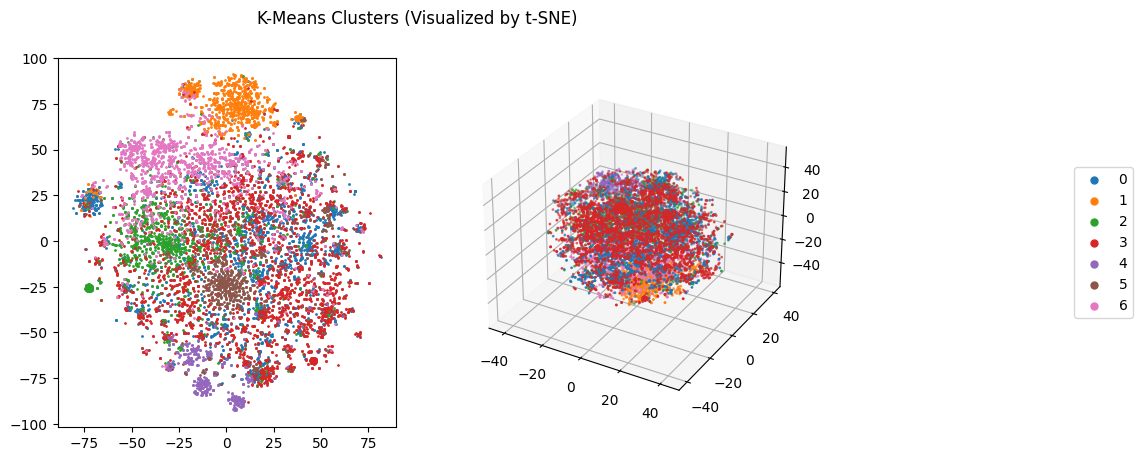

In [13]:
kmeans = KMeans(7)
kmeans_prediction = kmeans.fit_predict(vectors)

kmeans_clusters = unique(kmeans_prediction)

print(f"Number of Clusters: {len(kmeans_clusters)}")
print("10 Most common:")
print(Counter(kmeans_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for cluster in kmeans_clusters:
    index = where(kmeans_prediction == cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=cluster)

fig.suptitle("K-Means Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [14]:
kmeans_summary = clustering_summary(kmeans_prediction, test_data)
kmeans_summary

There are 7 different authors.
There are 91 different projects.


,Number of Messages,Number of different Authors,Median number of commits per different Author,Most common Author,Number of different Projects,Median number of commits per different Project,Most common project
0,2348.0,7.0,375.0,"('mark@mark-story.com', 661)",70.0,3.0,"('saltstack_salt', 820)"
1,1051.0,7.0,5.0,"('mike@silverorange.com', 969)",8.0,9.0,"('silverorange_swat', 969)"
2,1463.0,7.0,263.0,"('marijnh@gmail.com', 435)",49.0,2.0,"('saltstack_salt', 524)"
3,3080.0,7.0,460.0,"('thatch45@gmail.com', 1078)",73.0,4.0,"('saltstack_salt', 1630)"
4,497.0,4.0,50.0,"('pedro@algarvio.me', 396)",7.0,3.0,"('saltstack_salt', 483)"
5,901.0,7.0,73.0,"('mark@mark-story.com', 465)",34.0,2.0,"('cakephp_cakephp', 452)"
6,1344.0,7.0,100.0,"('marijnh@gmail.com', 683)",48.0,2.0,"('codemirror_CodeMirror', 579)"


In [15]:
kmeans_summary.describe()

,Number of Messages,Number of different Authors,Median number of commits per different Author,Number of different Projects,Median number of commits per different Project
count,7.000000,7.000000,7.000000,7.000000,7.000000
mean,1526.285714,6.571429,189.428571,41.285714,3.571429
std,894.686484,1.133893,177.043175,26.681543,2.507133
min,497.000000,4.000000,5.000000,7.000000,2.000000
25%,976.000000,7.000000,61.500000,21.000000,2.000000
50%,1344.000000,7.000000,100.000000,48.000000,3.000000
75%,1905.500000,7.000000,319.000000,59.500000,3.500000
max,3080.000000,7.000000,460.000000,73.000000,9.000000


In [16]:
clustering_spacy_evaluation(kmeans_prediction, test_data)

,0,1,2,3,4,5,6
length_mean,93.794719,74.790676,69.572112,61.279870,56.032193,78.822420,94.701637
length_std,73.929709,47.667457,45.531765,45.235103,38.827418,57.204014,62.211485
n_uppercase_mean,4.960818,3.647003,3.680109,2.246753,2.086519,3.335183,5.280506
n_uppercase_std,5.871799,3.559477,3.320259,3.123563,2.293934,3.882968,4.906662
polarity_mean,-0.002398,0.031686,0.009407,0.025336,0.011373,-0.014537,0.016334
polarity_std,0.191702,0.171658,0.184454,0.171863,0.110742,0.190616,0.182940
subjectivity_mean,0.210697,0.173747,0.180854,0.180693,0.077934,0.193439,0.249918
subjectivity_std,0.280613,0.284332,0.284717,0.286340,0.202242,0.263983,0.289456


In [17]:
print_clustering_classes(kmeans_prediction, test_data)


________________ Class 0 ________________

___
1) 
API CHANGE Removed Member::init_db_fields(), its no longer needed due to the Member.PasswordEncyrption property changing from an ENUM to Varchar.

git-svn-id: svn://svn.silverstripe.com/silverstripe/open/modules/sapphire/branches/<I>@<I> <I>b<I>ca-7a2a-<I>-9d3b-<I>d<I>a<I>a9
___
2) 
BUGFIX: Make sure CMS link knows when its currently in the CMS (from r<I>)

git-svn-id: svn://svn.silverstripe.com/silverstripe/open/modules/sapphire/branches/<I>@<I> <I>b<I>ca-7a2a-<I>-9d3b-<I>d<I>a<I>a9
___
3) 
MINOR ArrayLib - removed unncessary extending of Object since this class only has a bunch of static functions (from r<I>)

git-svn-id: svn://svn.silverstripe.com/silverstripe/open/modules/sapphire/trunk@<I> <I>b<I>ca-7a2a-<I>-9d3b-<I>d<I>a<I>a9
___
4) 
BUGFIX: Fix image tracking not working cross subsite (from r<I>) (from r<I>)

git-svn-id: svn://svn.silverstripe.com/silverstripe/open/modules/cms/trunk@<I> <I>b<I>ca-7a2a-<I>-9d3b-<I>d<I>a<I>a9
___